<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">MODEL EVALUATION AND HYPERPARAMETER TUNING</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 6:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Pipelines](#1)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. $k$-fold cross-validation](#2)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Learning and validation curves](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. Learning curves](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Validation curves](#3b)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[4. Grid search and randomized search](#4)</p>
        <p style="margin: 0 0 0 4rem">[4a. Grid search](#4a)</p>
        <p style="margin: 0 0 0 4rem">[4b. Randomized search](#4b)</p>
        <p style="margin: 0 0 0 4rem">[4c. Search with successive halving](#4c)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[5. Different evaluation metrics](#5)</p>
        <p style="margin: 0 0 0 4rem">[5a. Confusion matrix](#5a)</p>
        <p style="margin: 0 0 0 4rem">[5b. Accuracy, error, recall and precision of a classification model](#5b)</p>
        <p style="margin: 0 0 0 4rem">[5c. The receiver operating characteristic (ROC)](#5c)</p>
        <p style="margin: 0 0 0 4rem">[5d. Scoring metrics for multiclass classification](#5d)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[Appendix - Dealing with class imbalance](#Appendix)</p></div>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

# The datasets we will use
df = pd.read_csv('wdbc.data', header=None)

# Beautify the code results by using colors
from colorama import Fore, Back, Style
# define some strings for cleaner codes
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT
YB = Fore.YELLOW + Style.BRIGHT

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. PIPELINES</font></h4>$\quad$
        In this chapter, we will be working with the Breast Cancer Wisconsin dataset, which contains 569 examples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID numbers of the patients and the corresponding diagnoses (M = malignant, B = benign), respectively. Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.<br>$\quad$
        First we download the dataset, then we split it into training and test datasets (with $80\%$ into training). The labels are ' <font color='purple'>B</font> ' and ' <font color='purple'>M</font> ', so we first use <font color='green'>scikit-learn</font>'s ' <font color='green'>LabelEncoder</font> ' to transform them into $0$ and $1$ respectively :

In [2]:
# reads the "wdbc.data" in the folder; this dataset has no header
df = pd.read_csv('wdbc.data', header=None)

from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
print(YB + "B" + BB + " and " + YB + "M" + BB + " are now replaced by" + MB, 
      le.transform(["B"])[0], BB + "and" + MB, le.transform(["M"])[0], BB+ "respectively")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)
print(BB + "And the original dataset has been divided into a training and a test datasets," +
      " with the ratio 80-20%.")

B and M are now replaced by 0 and 1 respectively
And the original dataset has been divided into a training and a test datasets, with the ratio 80-20%.


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The learning algorithms we are going to use require input features on the same scale for optimal performance, but the features in the Breast Cancer Wisconsin dataset are measured on various different scales, so we need to standardize the columns of our training matrix. Then we want to compress our data from the initial $30$ dimensions into a lower $2$-dimensional subspace via principal component analysis (PCA, see part 5, "1. Principal component analysis"). At last we apply a logistic regression algorithm (see part 3, "2. The logistic regression"). Rather than fitting these transformations one after the other on the training dataset, and then transform our test dataset with these operations one after the other, we can chain the three transformations into a pipeline, using ' <font color='green'>make_pipeline</font> ' from <font color='green'>scikit-learn</font>'s '<font color='green'>pipeline</font>' module.<br>$\quad$
    <font color='green'>make_pipeline</font> takes an arbitrary number of <font color='green'>scikit-learn</font> transformers (objects that support the fit and transform methods as input), followed by a <font color='green'>scikit-learn</font> estimator that implements the fit and predict methods. In this example, we provide two <font color='green'>scikit-learn</font> transformers, <font color='green'>StandardScaler</font> and <font color='green'>PCA</font>, and a <font color='green'>LogisticRegression</font> estimator as inputs to the <font color='green'>make_pipeline</font> function, thus building a <font color='green'>scikit-learn</font> <font color=darkpink>Pipeline<font color=darkblue>. We conclude by computing the test accuracy of our model :

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(BB + "Test accuracy :" + MB, round(test_acc, 3))

Test accuracy : 0.956


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's represent a general pipeline inner workings in a diagram :

<figure style="text-align: center;">
    <img src="6.1. Inner workings of a pipeline.png" alt="Figure showing the inner workings of a pipeline object. On the top-left enters the training dataset with the associated labels; it is scaled, the scaled matrix is then reduced to a lower dimension and at last an estimator is fit on the reduced matrix. Once the estimator is fit, enters the test dataset on the top-right; the same rescaling is applied on it to get a rescaled test dataset, which is itself reduced with the same transformer that was applied to the rescaled training dataset; at last we can ask for the predictions given by our fitted estimator on the obtained reduced test dataset; they are provided at the bottom right of the figure." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Inner workings of a pipeline</figcaption>
</figure>

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. $K$-FOLD CROSS-VALIDATION</font></h4>$\quad$
        Given a known dataset with enough instances, we often separate the training data into two parts : a training dataset, which is used to fit the different models, and a validation dataset, which is used to test the different models (or various choices of hyperparameters for a given type of algorithm) and choose the best one. The test dataset then gives a less biased estimate of the ability of the chosen algorithm to generalize to new data than if we used it to choose our model.<br>$\quad$
        A potential bias may occur when the number of instances is not large enough : the performance estimate may be very sensitive to how we partition the training dataset into the training and the validation subsets. One way of alleviating this bias is to follow the <font color='darkpink'>cross-validation algorithm</font> : randomly split our training dataset into a partition of $k$ parts, called " <font color='darkpink'>folds</font> ". We then cycle around the folds, taking one apart as a validation dataset, and uniting the other $(k\!-\!1)$ folds to constitute the associated training dataset; thus we get $k$ tests and their performance estimates instead of $1$ for our models. Once we have found a satisfactory model (or satisfactory hyperparameter values), we can retrain the model on the complete training dataset and obtain a final performance estimate using the independent test dataset.<br>$\quad$
        Note that larger values of $k$ will increase the runtime of the cross-validation algorithm. A good standard value for $k$ in $k$-fold cross-validation is $10$, "as empirical evidence shows". For smaller datasets, a larger $k$ may be used, up to the <font color='purple'>leave-one-out cross-validation</font> where the number of folds is equal to the number of training examples ($k$ = $m$) so that only one training example is used for testing during each iteration; this is a recommended approach for working with very small datasets. For larger datasets, a smaller $k$ may be used, eg $k=5$, which is the default value for <font color='green'>scikit-learn</font> cross-validation methods.<br>$\quad$
        A slight improvement over the standard $k$-fold cross-validation approach is the <font color='darkpink'>stratified $k$-fold cross-validation</font>, where the folds preserve the class label proportions of the training dataset, so that they are a better representation of the training dataset. <font color='green'>scikit-learn</font> uses this type of folds by default in the ' <font color='green'>cross_val_score</font> ' method (from its <font color='green'>model_selection</font> module), which yields the $k$ scores obtained by the algorithm in the $k$ tests that the method runs. By default, the scores are the results given by the estimator’s default scorer; for example for our pipeline, the estimator is the <font color='green'>LogisticRegression</font> whose default scorer returns the <font color='darkpink'>accuracy scores</font> (ie the ratio of correctly predicted instances to the total number of instances). Since these $k$ tests are partially random (run over stratified folds randomly chosen), a mean of these $k$ scores  is generally the most significant result we can get to estimate the quality of our algorithm before applying it to the test dataset.<br>$\quad$
        As an example, let's see the accuracy scores returned by the <font color='green'>cross_val_score</font> method and their mean and standard deviation for our pipeline over the 'wdbc.data' dataset:

In [4]:
from sklearn.model_selection import cross_val_score
# 'cv' is the number of folds; 'n_jobs' is the number of cores used by the method
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(BB + "The list of accuracy scores for our pipeline is\n" + MB, scores)
print(BB + "The mean of these accuracy scores is" + MB, round(np.mean(scores), 3),
      BB + "and its standard deviation is" + MB, round(np.std(scores), 3))

The list of accuracy scores for our pipeline is
 [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
The mean of these accuracy scores is 0.95 and its standard deviation is 0.014


<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. LEARNING AND VALIDATION CURVES</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. Learning curves</font><a id="3a"></a></p>$\quad$
        If a model is too complex for a given training dataset - eg a very deep decision tree - the model tends to overfit the training data and does not generalize well to unseen data. Often, it can help to collect more training examples to reduce the degree of overfitting. The interest of doing so can be assessed by plotting the curves of training and validation accuracies with respect to the number of instances we take into account from our dataset. These curves are called the "<font color='darkpink'>learning curves</font>" of our model.<br>$\quad$
        First, let's see the three main types of learning curves, and various ways to alleviate the corresponding problems, if any :

<figure style="text-align: center;">
    <img src="6.2. The three types of learning curves.png" alt="This diagram is divided into three figures, representing the three sets of typical learning curves. On each figure the x-axis represents the number of training samples, while the y-axis represents the accuracy scores; also, the desired accuracy is represented by a horizontal line. While the number of training samples grows, the training accuracies decrease but the validation accuracies improve. The top-left figure, titled 'High bias', represents the case of bad training (and validation) accuracy scores, even when the number of samples is large; the choice of the model or of its hyperparameters is bad. The top-right figure, titled 'High variance', represents the case of training accuracies that remain excellent, but validation accuracies remain less than ideal. And the bottom-right figure, titled 'Good bias-variance trade-off', shows training accuracies that decrease but stay above the desired accuracy, while the validation accuracies improve and converge towards the desired accuracy; both accuracies converge towards one another." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">The three types of learning curves</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    The top-left figure represents a model with bad training and cross-validation accuracy scores, which indicates that it underfits the training data. Common ways to address this issue are to increase the number of model parameters, or to increase the number of features, or to decrease the degree of regularization, if any (see part 4, "4a. $L^1$ and $L^2$ regularizations").<br>$\quad$
    The graph in the upper-right shows a model that suffers from high variance, which is indicated by the large gap between the training and the cross-validation accuracy scores. To address this problem of overfitting, we can collect more training data, reduce the complexity of the model, decrease the number of features via feature selection (see part 4, "4. Selecting meaningful features") or feature extraction (see part 5, "Dimensionality reduction"), or increase the regularization parameter. While collecting more training data usually tends to decrease the chance of overfitting, it may not always help, for example, if the training data is extremely noisy or the model is already very close to optimal.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    With the next code, we plot the learning curves of a pipeline composed of the <font color='green'>StandardScaler</font> and the <font color='green'>LogisticRegression</font> with an $L^2$ regularization applied to the 'wdbc.data' dataset. We use the ' <font color='green'>learning_curve</font> ' method from the <font color='green'>scikit-learn</font>'s <font color='green'>model_selection</font> module; among its parameters we have : the <font color='green'>estimator</font> (the algorithm under test), <font color='green'>X</font> (the training matrix), <font color='green'>y</font> (the training labels), <font color='green'>train_sizes=array([0.1, 0.33, 0.55, 0.78, 1])</font> (an array of proportions of the training set at which to compute the training and validation accuracy scores), <font color='green'>cv=None</font> (the number of cross-validation folds - $5$ by default -), and <font color='green'>n_jobs=None</font> (the number of CPU cores to use for parallel execution - $1$ by default -).<br>
    By default, <font color='green'>learning_curve</font> uses stratified $k$-fold cross-validation to calculate
the cross-validation accuracy scores of a classifier.<br>
    <font color='green'>learning_curve</font> returns : the <font color='green'>train_sizes_abs</font> (the list of numbers of training examples that has been used to generate the learning curves); the <font color='green'>train_scores</font> (the matrix whose $i$-th row is composed of the accuracy scores obtained by the algorithm when it was trained on a number of instances which is the $i$-th value of <font color='green'>train_sizes</font>, on the various $k$ folds obtained from the training matrix); the <font color='green'>test_scores</font> (the same matrix, but when the $k$ folds are obtained from the test dataset); the <font color='green'>fit_times</font> (the corresponding list of times spent for fitting - in seconds -); and the <font color='green'>score_times</font> (the corresponding list of times spent for scoring - in seconds -).

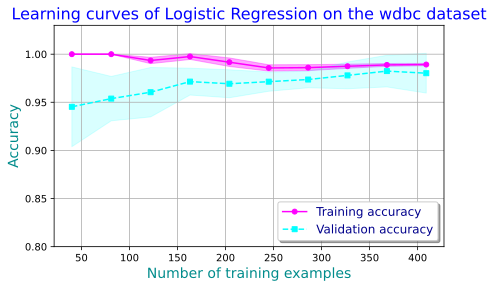

In [5]:
from sklearn.model_selection import learning_curve
# 'StandardScaler' standardizes the features by removing the mean and scaling to unit variance
# 'LogisticRegression' uses the l2 regularization with C=1 by default
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter=10000))
# 'np.linspace(0.1, 1, 10)' generates 10 equally spaced values from 0.1 to 1 (inclusive)
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                            train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=1)
# the list of the means of each row (ie when we count all the columns - axis=1 -)
train_mean = np.mean(train_scores, axis=1)
# the list of the standard deviations along the rows
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(7, 4))
plt.title("Learning curves of Logistic Regression on the wdbc dataset", fontsize=16, color='blue')
plt.plot(train_sizes, train_mean, marker='o', markersize=5, color=cmap(0.999), label="Training accuracy")
# 'plt.fill_between' fills the area between two curves, here in magenta with 35% opacity
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.35,
                 color=cmap(0.999))
plt.plot(train_sizes, test_mean, linestyle='--', marker='s', markersize=5, color=cmap(0),
         label="Validation accuracy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color=cmap(0))
plt.grid()
plt.xlabel("Number of training examples", fontsize=14, color='darkcyan')
plt.ylabel("Accuracy", fontsize=14, color='darkcyan')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.ylim([0.8, 1.03])
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Validation curves</font><a id="3b"></a></p>$\quad$
    While learning curves show the training and test accuracies as functions of the sample size, "<font color='darkpink'>validation curves</font>" show the training and test accuracies as functions of a hyperparameter that we want to optimize. For example, suppose that we want to optimize the inverse regularization parameter $C$ in our current model. We use the ' <font color='green'>validation_curve</font> ' method from <font color='green'>scikit-learn</font>'s <font color='green'>model_selection</font> module; among its parameters we have : the <font color='green'>estimator</font> (the algorithm family under test), <font color='green'>X</font> (the training matrix), <font color='green'>y</font> (the training labels), the <font color='green'>param_name</font> (the name of the hyperparameter that we want to optimize; the name is built as follows :<br>$\qquad$<font color='darkpink'>
    'name of the method in the pipeline'+'__'(dunder)+'name of the hyperparameter'</font> $\quad$ eg $\;\;$<font color='purple'>'logisticregression__C'</font><br>
), the <font color='green'>param_range</font> (the list of values of the hyperparameter with which to compute the training and validation accuracy scores), <font color='green'>cv=None</font> (the number of cross-validation folds - $5$ by default -), and <font color='green'>n_jobs=None</font> (the number of CPU cores to use for parallel execution - $1$ by default -).<br>
    Similar to the <font color='green'>learning_curve</font> function, the <font color='green'>validation_curve</font> function uses stratified $k$-fold cross-validation by default to calculate the cross-validation accuracy scores of a classifier.<br>
    <font color='green'>validation_curve</font> returns : the <font color='green'>train_scores</font> (the matrix whose $i$-th row is composed of the accuracy scores obtained by the algorithm when its hyperparameter takes the $i$-th value of the <font color='green'>param_range</font>, on the various $k$ folds obtained from the training matrix); and the <font color='green'>test_scores</font> (the same matrix, but when the $k$ folds are obtained from the test dataset).

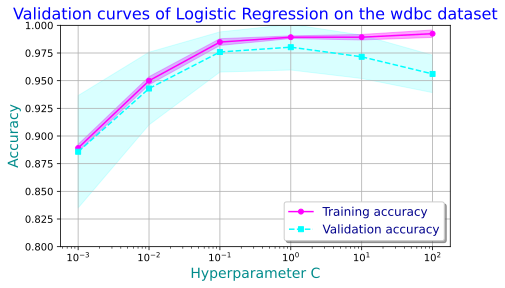

In [6]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(7, 4))
plt.title("Validation curves of Logistic Regression on the wdbc dataset", fontsize=16, color='blue')
plt.plot(param_range, train_mean, marker='o', markersize=5, color=cmap(0.999), label="Training accuracy")
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.35,
                 color=cmap(0.999))
plt.plot(param_range, test_mean, linestyle='--', marker='s', markersize=5, color=cmap(0),
         label="Validation accuracy")
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color=cmap(0))
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.xlabel("Hyperparameter C", fontsize=14, color='darkcyan')
plt.ylabel("Accuracy", fontsize=14, color='darkcyan')
plt.ylim([0.8, 1.0])
plt.show()

<a id="4"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>4. GRID SEARCH AND RANDOMIZED SEARCH</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4a. Grid search</font><a id="4a"></a></p>$\quad$
        In the previous section, we used validation curves to improve the performance of a model by tuning one of its hyperparameters. In this section, we will take a look at a popular hyperparameter optimization technique called grid search, which can further help to improve the performance of a model by finding the optimal combination of hyperparameter values. Grid search simply means trying various associations of hyperparameter values and choose the best one by comparing scores, in general the cross-validation accuracy scores. It is implemented in the ' <font color='green'>GridSearchCV</font> ' class of <font color='green'>scikit-learn</font>'s <font color='green'>model_selection</font> module. <font color='green'>GridSearchCV</font> is not directly applied to any dataset, rather it contains : the <font color='green'>estimator</font>; the set of hyperparameters and the values that we want to try (see below); the number <font color='green'>cv</font> of folds for the cross-validations; the type of <font color='green'>scoring</font> that we want to use, usually <font color='green'>scoring='accuracy'</font>, the default; the number of CPU cores that we want to use, eg <font color='green'>n_jobs=-1</font> to use all available cores; and the <font color='green'>refit</font> parameter, which is <font color='green'>True</font> by default, so that fitting <font color='green'>GridSearchCV</font> to a training matrix would mean fitting the best estimator among those tested. By the way, if 'gs' is the name of the <font color='green'>GridSearchCV</font>, then<br>$\quad$
    clf := <font color='green'>gs.fit(X_train, y_train).best_estimator_</font><br>
will be the best estimator among the specified group for our training dataset. Then <font color='green'>gs.best_score_</font> will return the mean of the cross-validation scores of 'clf', and <font color='green'>gs.best_params_</font> will return the best values among those tested.<br>$\quad$
    The goal of <font color='green'>GridSearchCV</font> is to test some values for some hyperparameters. These are specified as a value of the <font color='green'>param_grid</font> parameter. <font color='green'>param_grid</font> should be a list of dictionaries whose keys are the names of the hyperparameters, and whose values are the lists of the values that we want to try. As previously mentioned, the names of the hyperparameters are built as follows :<br>$\qquad$<font color='darkpink'>
    'name of the method in the pipeline'+'__'(dunder)+'name of the hyperparameter'</font> $\quad$ eg $\;\;$<font color='purple'>'logisticregression__C'<br>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    As an example, let's try to find the best SVM among a bunch of possibilities.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator is\n" + MB, clf)
print(BB + "The mean of its accuracy scores over all the 10-folds is" + MB, gs.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, gs.best_params_)
print(BB + "Its accuracy score over the test dataset is" + MB, round(clf.score(X_test, y_test), 3))

The best estimator is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])
The mean of its accuracy scores over all the 10-folds is 0.9846859903381642
The best values for the tested hyperparameters are
 {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Its accuracy score over the test dataset is 0.974


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4b. Randomized search</font><a id="4b"></a></p>$\quad$
        Instead of chosing by ourselves the parameters to check we can implement a randomized search. This is done by : replacing '$\,$<font color='green'>param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]</font>$\,$' with '$\,$<font color='green'>param_range = scipy.stats.loguniform(0.0001, 1000.0)</font>$\,$' ; by using <font color='green'>RandomizedSearchCV</font> instead of <font color='green'>GridSearchCV</font> ; and by specifying the total number <font color='green'>nb</font> of values to try via <font color='green'>n_iter=nb</font>. Note that in the previous non-randomized search we used $\,8+8\times8\,=\,72\,$ sets of values, and here we only use $20$. Moreover the results will depend on these random values obtained for the hyperparameters.

In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_range = scipy.stats.loguniform(0.0001, 1000.0)
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# pipe_svc is defined cell 7
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid, scoring='accuracy',
                        n_iter=20, cv=10, refit=True, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
clf = rs.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator is\n" + MB, clf)
print(BB + "The mean of its accuracy scores over all the 10-folds is" + MB, rs.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, rs.best_params_)
print(BB + "Its accuracy score over the test dataset is" + MB, round(clf.score(X_test, y_test), 3))

The best estimator is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.05971247755848463, kernel='linear', random_state=1))])
The mean of its accuracy scores over all the 10-folds is 0.9780676328502416
The best values for the tested hyperparameters are
 {'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}
Its accuracy score over the test dataset is 0.974


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4c. Search with successive halving</font><a id="4c"></a></p>$\quad$
        Taking the idea of randomized search one step further, <font color='green'>scikit-learn</font> implements a <font color='purple'>successive halving</font> variant, ' <font color='green'>HalvingRandomSearchCV</font> ', that makes finding suitable hyperparameter configurations more efficient. Successive halving, given a large set of candidate configurations, successively throws out unpromising hyperparameter configurations until only one configuration remains. We can summarize the procedure via the following steps:
1. Draw a large set of candidate configurations via random sampling (a "candidate configuration" being a set of hyperparameter values)
2. Train the models with limited resources, for example a small subset of the training data (as
opposed to using the entire training set)
3. Keep only a given proportion of the remaining candidates, based on predictive performance
4. Go back to step 2 with an increased amount of available resources

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    According to ChatGPT, first <font color='green'>scikit-learn</font> decides on how much resources to allocate to the problem at hand, based on the specified parameters and the available computational resources. From this it infers the initial number of candidates, depending on various parameters such as the number of folds <font color='green'>cv</font>; the default value for <font color='green'>cv</font> is $5$. Then, at each round, if there are $nb$ candidates then <font color='green'>scikit-learn</font> will only keep the best $nb'$ of them, $nb'$ being $nb$ divided by the <font color='green'>factor</font> parameter (in fact $nb'$ will be the integer just above this fraction). This strategy will decide the number of rounds, depending on the <font color='green'>factor</font>, <font color='green'>n_candidates</font> and <font color='green'>resource</font> parameters; their default values being $3$, <font color='green'>'exhaust'</font> and <font color='green'>'n_samples'</font> respectively, meaning that at the last round all the samples must be used and that the resource that increases with each iteration is the number of samples used, so that if the proportion of kept candidates is the inverse of <font color='green'>factor</font> then the number of samples used is multiplied by <font color='green'>factor</font>.<br>$\quad$
    Note that the number of candidates at each round is given by the attribute <font color='green'>n_candidates_</font>.

In [9]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

param_range = scipy.stats.loguniform(0.0001, 1000.0)
param_grid = {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['linear', 'rbf']}
# pipe_svc is defined cell 7
hs = HalvingRandomSearchCV(pipe_svc, param_distributions=param_grid, n_candidates='exhaust',
                           resource='n_samples', factor=2, cv=5, random_state=1, n_jobs=-1)
hs = hs.fit(X_train, y_train)
print(BB + "The number of sets of hyperparameters considered at each round is\n" + MB,
      hs.fit(X_train, y_train).n_candidates_)
clf = hs.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator is\n" + MB, clf)
print(BB + "The mean of its accuracy scores over all the 5-folds is" + MB, hs.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, hs.best_params_)
print(BB + "Its accuracy score over the test dataset is" + MB, round(clf.score(X_test, y_test), 3))

The number of sets of hyperparameters considered at each round is
 [22, 11, 6, 3, 2]
The best estimator is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=4.877780549954556, gamma=353.8127634797474,
                     kernel='linear', random_state=1))])
The mean of its accuracy scores over all the 5-folds is 0.9625
The best values for the tested hyperparameters are
 {'svc__C': 4.877780549954556, 'svc__gamma': 353.8127634797474, 'svc__kernel': 'linear'}
Its accuracy score over the test dataset is 0.982


<br><span style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    So, using only $45$ sets of values for our hyperparameters we get results comparable to the results we got with the grid-search method where we used $72$ sets of values (see "4a. Grid search").

<a id="5"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>5. DIFFERENT EVALUATION METRICS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5a. Confusion matrix</font><a id="5a"></a></p>$\quad$
        A confusion matrix is a matrix $C$ whose coefficient $C_{ij}$ is the number of instances of class $i$ that have been predicted to be of class $j$.<br>$\quad$
        In the case of a binary classification task we call <font color='darkpink'>positive element</font>, or more simply <font color='darkpink'>positive</font>, any element of class $1$. And <font color='darkpink'>negative element</font>, or more simply <font color='darkpink'>negative</font>, any element of class $0$.<br>
    Consequently the upper left element of a confusion matrix will correspond to the <font color='darkpink'>true negatives</font> (<font color='darkpink'>TN</font>), ie to the negatives that have been correctly predicted; while the upper right element will correspond to the <font color='darkpink'>false positives</font> (<font color='darkpink'>FP</font>), ie to the negative elements that have been wrongly predicted as positives. The second row will be composed of the <font color='darkpink'>false negatives</font> (<font color='darkpink'>FN</font>), ie to the positive elements that have been predicted as negatives, and of the <font color='darkpink'>true positives</font> (<font color='darkpink'>TP</font>), ie to the positive elements that have been correctly predicted.<br><br>$\quad$
        Although these numbers can be easily computed manually by comparing the actual and predicted class
labels, <font color='green'>scikit-learn</font> provides a convenient <font color='green'>confusion_matrix</font> function that we can use as follows:

In [10]:
from sklearn.metrics import confusion_matrix
# pipe_svc is defined cell 7
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(BB + "Confusion matrix :\n" + MB, confmat)

Confusion matrix :
 [[71  1]
 [ 2 40]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can display a neater confusion matrix, using <font color='green'>Matplotlib</font> and its <font color='green'>matshow</font> function :

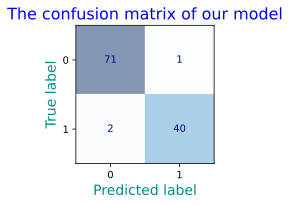

In [11]:
# creates a figure and a set of subplots. 'fig' represents the entire figure, while 'ax' represents a
# single subplot within that figure. The figsize=(2.5, 2.5) parameter specifies the size of the figure
# to be 2.5 inches by 2.5 inches when printed on a support with 100dpi (dots per inch).
fig, ax = plt.subplots(figsize=(2.5, 2.5))
plt.title("The confusion matrix of our model", fontsize=16, color='blue')
# displays the confusion matrix using the 'matshow' function of the subplot 'ax'. 'confmat' is the
# NumPy array representing the confusion matrix defined in the previous cell. The 'cmap=plt.cm.Blues'
# argument sets the colormap to 'Blues', which will be used to color the matrix elements; 'Blues'
# consists of shades of blue ranging from light to dark, the higher the number the darker the 
# corresponding blue. The 'alpha=0.5' parameter sets the transparency level to 0.5, making the matrix
# moderately transparent, which helps distinguish the numbers (written in black) on the darker blue
# areas
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
# this loop iterates over the rows of the 'confmat' array
for i in range(confmat.shape[0]):
    # this nested loop iterates over the columns of the 'confmat' array
    for j in range(confmat.shape[1]):
        # in Matplotlib 'x' (resp. 'y') corresponds to the columns (resp. rows). Moreover, the
        # 'va='center'' and 'ha='center'' arguments specify that the text should be vertically and
        # horizontally centered within each cell
        ax.text(y=i, x=j, s=confmat[i, j], va='center', ha='center', color='darkblue')
# Set x-axis' ticks positions to bottom only
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label', fontsize=14, color='darkcyan')
plt.ylabel('True label', fontsize=14, color='darkcyan')
plt.show()

<br><span style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Since our class $1$ corresponds to the malignant tumors (see cell $2$) and is the positive class, our model correctly classified $71$ benign tumors (TN) and $40$ malignant tumors (TP). Moreover, our model also incorrectly misclassified $2$ malignant tumors as benign (FN), and $1$ benign tumor as malignant (FP).

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5b. Accuracy, error, recall and precision of a classification model</font><a id="5b"></a></p>$\quad$
        There are many binary classification tasks (eg predicting whether a written number is a $5$ or not) in which we only focus on the ratio of correct predictions, not on the particular ratio of elements of class $0$ (negatives) or of class $1$ (positives) that are correctly predicted. The ratio of correct predictions is called the accuracy, so by default in <font color='green'>scikit-learn</font> a model is considered better than another iff it has a greater accuracy (score).<br>$\quad$
        But there are also many binary classification tasks (eg predicting whether a cancer is benign or malignant) in which it makes sense to consider separately the ratio of positives that are incorrectly predicted (eg the ratio of malignant cancers that are incorrectly classified - thus failing to recognize the urgency of the treatment -) and the ratio of negatives that are incorrectly predicted (eg the ratio of benign cancers that are predicted as malignant - thus worrying the patient unnecessarily -). For these tasks, the accuracy score is not enough.<br>$\quad$
        In order to deal with all possible binary classification tasks we use various scoring methods. Using the notations of "5a. Confusion matrix", we define :
* The <font color='darkpink'>(prediction) accuracy (score)</font> is, as usual, the ratio of correct predictions :<br><font color = darkpink>
        $$ACC \;=\; \frac{TN+TP}{TN+TP+FN+FP} \,\qquad (1)$$</font><br>
* The <font color='darkpink'>(prediction) error</font> is the ratio of wrong predictions :<br><font color = darkpink>
        $$ERR \;=\; \frac{FN+FP}{TN+TP+FN+FP} \;=\; 1-ACC \,\qquad (2)$$</font><br>
* The <font color='darkpink'>recall</font>, or <font color='darkpink'>true positive rate</font>, is the ratio of positives that are correctly predicted :<br><font color = darkpink>
        $$REC \;=\; TPR \;=\; \frac{TP}{TP+FN} \,\qquad (3)$$</font><br>
* The <font color='darkpink'>false positive rate</font> is the ratio of negatives that are incorrectly predicted :<br><font color = darkpink>
        $$FPR \;=\; \frac{FP}{TN+FP} \,\qquad (4)$$</font><br>
* The <font color='darkpink'>precision</font> is the ratio of true positives in the set of elements that are predicted as positives :<br><font color = darkpink>
        $$PRE \;=\; \frac{TP}{TP+FP} \,\qquad (5)$$</font>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Thus optimizing the recall is equivalent to trying to catch all the positives. In our example of cancerous cells, this means to try and catch all the malignant tumors. This usually goes with an augmentation of the false positives, ie a lesser precision. In our example, this means worrying more patients unnecessarily. To balance the pros and cons of optimizing PRE and REC, the harmonic mean of PRE and REC is used; it is called the <font color='darkpink'>$\,F1$ score</font> :<br><font color='darkpink'>
    $$F1 \;=\; 2 \, \frac{REC \times PRE}{REC+PRE} \,\qquad (6)$$</font><br>$\quad$
    Harder to interpret than the $\,F1$ score, but regarded as a superior metric, is the <font color='purple'>Matthews correlation coefficient</font> (<font color='purple'>MCC</font>) :<br><font color = purple>
    $$MCC \;=\; \frac{TN \times TP \,-\, FN \times FP}{\sqrt{(TN+FP)(FN+TP)(TN+FN)(FP+TP)}} \,\qquad (7)$$</font><br><br>$\quad$
        These scoring metrics are all implemented in the <font color='green'>sklearn.metrics</font> module of <font color='green'>scikit-learn</font> :

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
print(BB + "The accuracy score over the test dataset is" + MB,
      round(accuracy_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The recall score over the test dataset is" + MB,
      round(recall_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The precision score over the test dataset is" + MB,
      round(precision_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The F1 score over the test dataset is" + MB,
      round(f1_score(y_true=y_test, y_pred=y_pred), 3))
print(BB + "The MCC score over the test dataset is" + MB,
      round(matthews_corrcoef(y_true=y_test, y_pred=y_pred), 3))

The accuracy score over the test dataset is 0.974
The recall score over the test dataset is 0.952
The precision score over the test dataset is 0.976
The F1 score over the test dataset is 0.964
The MCC score over the test dataset is 0.943


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    The <font color='green'>sklearn.metrics</font> module contains a function, <font color='green'>make_scorer</font>, which transforms any metric or loss function from the following list :<br>$\qquad$
        https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values </font><br>
into what is called a <font color='purple'>scorer</font>. In estimators and functions having a <font color='green'>scoring</font> parameter, it is possible to use any of these scorers instead of the default <font color='green'>scoring</font> method. It is also possible to use one's own scorers, that can be defined as explained below this list, but we do not need these here.<br>$\quad$
    For example, using the $\,F1$ score instead of the usual accuracy score in our grid search, would lead to the same best estimator than the one obtained in cell $7$ (with a $\,F1$ score different than the accuracy score). But using the precision score instead would lead to a different best estimator :

In [13]:
from sklearn.metrics import make_scorer

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gsf1 = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=make_scorer(f1_score), cv=10,
                  refit=True, n_jobs=-1)
clf = gsf1.fit(X_train, y_train).best_estimator_
print(BB + "The best estimator when using the F1 score is\n" + MB, clf)
print(BB + "The mean of its F1 scores over all the 10-folds is" + MB, gsf1.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, gsf1.best_params_)
print(BB + "Its F1 score over the test dataset is" + MB, round(clf.score(X_test, y_test), 3))

The best estimator when using the F1 score is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])
The mean of its F1 scores over all the 10-folds is 0.9785984848484848
The best values for the tested hyperparameters are
 {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Its F1 score over the test dataset is 0.974


In [14]:
# Custom scoring function with zero_division set to 0 (this function will not be used, but it is necessary
# to run the code in Sagemaker Studio Lab without getting tons of warnings; its goal is to tell what to do
# in case there would be a division by 0, ie in case there would be no positives; we could set
# 'zero_division=1' or whatever value we want)
def custom_precision_score(y_true, y_pred):
    return precision_score(y_true, y_pred, zero_division=0)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gsp = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=make_scorer(custom_precision_score),
                   cv=10, refit=True, n_jobs=-1)

# Fit the model and get the best estimator
clf = gsp.fit(X_train, y_train).best_estimator_

# Output the results
print(BB + "The best estimator when using the precision score is\n" + MB, clf)
print(BB + "The mean of its precision scores over all the 10-folds is" + MB, gsp.best_score_)
print(BB + "The best values for the tested hyperparameters are\n" + MB, gsp.best_params_)
print(BB + "Its precision score over the test dataset is" + MB, round(clf.score(X_test, y_test), 3))

The best estimator when using the precision score is
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.01, kernel='linear', random_state=1))])
The mean of its precision scores over all the 10-folds is 1.0
The best values for the tested hyperparameters are
 {'svc__C': 0.01, 'svc__kernel': 'linear'}
Its precision score over the test dataset is 0.956


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5c. The receiver operating characteristic (ROC)</font><a id="5c"></a></p>$\quad$
        In many classification algorithms, including logistic regression, support vector machines, and random forests, the model doesn't directly output class labels (e.g., $0$ or $1$ for binary classification). Instead, it predicts probabilities that an instance belongs to each class.<br>$\quad$
        A <font color='darkpink'>decision threshold</font> is a value between $0$ and $1$ that is used to convert these probabilities into actual class predictions. If the predicted probability of the positive class (class $1$) is equal to or greater than the decision threshold, then the instance is classified as positive; otherwise, it is classified as negative.<br>$\quad$
        Note that the denominator of the recall (or true positive rate), $\,(TP+FN)\,$, is the total number of positive instances, while the denominator of the false positive rate, $\,(TN+FP)\,$, is the total number of negative instances, so these quantities do not depend on the value of the threshold. Suppose that they are not zero - ie there are positive and negative instances -, so that the recall REC and the false positive rate FPR are defined. <font color='purple'>If the threshold is $0$ then</font> all instances will be predicted as positives; hence TN and FN will be equal to $0$, so <font color='purple'>REC and FPR will be equal to $1$</font>. Conversely, <font color='purple'>if the threshold is equal to $1$ then</font> all instances will be predicted as negatives, TP and FP will be equal to $0$, and <font color='purple'>REC and FPR will be equal to $0$</font>.<br>$\quad$
        Moreover when the threshold goes from $0$ to $1$, only the numerators of the REC and of the FPR do change, and they decrease, so the REC and the FPR decrease; as we have just mentioned, they decrease from $1$ to $0$.<br><br>$\quad$
                For any threshold $\,t\in[0,1]\,$ we can compute the corresponding FPR and REC, say $\,xt\,$ and $\,yt\,$, and then place the point $\,(xt,yt)\,$ on a diagram. The method is called the <font color='darkpink'>receiver operating characteristic</font> (<font color='darkpink'>ROC</font>); the curve is called the <font color='darkpink'>ROC curve</font>.<br>$\quad$
    If we follow the ROC curve in ascending order of the FPR from $0$ to $1$, the corresponding thresholds decrease from $1$ to $0$, and thus the REC increases from $0$ to $1$. Hence <font color='darkpink'>the ROC of any classifier corresponds to an increasing function which goes from $(0,0)$ to $(1,1)$</font>.<br>$\quad$
    Note that if the predictions were made randomly (according to an equally distributed law), then each instance would get a number from $0$ to $1$ such that in total if the decision threshold is $t$ then the proportion of instances that would be predicted as negative would be $t$. If $P$ is the number of positive instances then $\,tP\,$ of them would be predicted as negatives and $\,(1\!-\!t)P\,$ would be predicted as positives; consequently the number of true positives would be $\,TP=(1\!-\!t)P\,$, so the recall would be $\,REC=1-t\,$. And if $N$ is the number of negative instances then $\,tN\,$ would be true negatives and $\,(1\!-\!t)N\,$ would be false positives; so the false positive rate would be $\,FPR=1-t\,$. Hence <font color='darkpink'>if the predictions are made randomly then</font>, for any threshold $t$, RED and FPR would be equal, to $1\!-\!t$; so in this case <font color='darkpink'>the ROC curve is the linear curve $\,y=x\,$</font>.<br>$\quad$
    Any decent predictive model satisfies $\,REC \geq FPR\,$ (ie the ratio of correctly predicted positives is greater than the ratio of negatives incorrectly predicted) for at least one threshold $t_0$ (the one it uses for making its predictions). This corresponds to a point that is above the line $\,y=x\,$.<br>
    Some models may satisfy $\,REC \geq FPR\,$ at some thresholds and not satisfy this inequality at other thresholds. For such models, the thresholds corresponding to the part of the ROC which is under the line $\,y=x\,$ (ie $\,REC<FPR\,$) must be discarded, since they correspond to predictions that are worse than random guessing.<br>$\quad$
    Note also that a perfect classifier would have a recall of $1$ and a FPR of $0$ at a given threshold. Then if we continuously decrease the threshold more elements will be predicted as positives, so the recall will remain $1$ while the FPR will increase, up to $1$ (when the threshold is $0$ or earlier); hence <font color='darkpink'>the ROC curve of a perfect classifier is the vertical line from $(0,0)$ to $(0,1)$ followed by the horizontal line from $(0,1)$ to $(1,1)$</font>.<br><br>$\quad$
                Often associated with the ROC is the <font color='darkpink'>ROC area under the curve</font> (<font color='darkpink'>ROC AUC</font>), which is the value of the surface area under the ROC.<br>$\quad$
    A random guessing will have a ROC AUC of $0.5$, while a perfect classifier will have a ROC AUC of $1$. We can compare the ROC AUC of an estimator to these numbers to get an idea of its quality across different threshold values; or compare the quality of two estimators using their respective ROC AUC, a higher ROC AUC generally indicating a better discrimination ability of the model.<br><br>$\quad$
                The ROC curve and the ROC AUC are implemented in the <font color='green'>sklearn.metrics</font> module of <font color='green'>scikit-learn</font> under the names <font color='green'>roc_curve</font> and <font color='green'>roc_auc_score</font> respectively. We will use them now for a classifier that only uses two features from the Breast Cancer Wisconsin dataset to predict whether a tumor is benign or malignant. Although we are going to use the same logistic regression pipeline that we defined previously, we are only using two features this time. This is to make the classification task more challenging for the classifier, by withholding useful information contained in the other features, so that the resulting ROC curve becomes visually more interesting. For similar reasons, we are also reducing the number of folds in the <font color='green'>StratifiedKFold</font> validator to $3$ (for the definition of stratified k-folds see "2. k-fold cross validation") :<br><br>$\quad$
                <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Notes :</font></p> $\quad$
    1. the code provided in the book does not use the <font color='green'>roc_auc_score</font> but a more general <font color='green'>scikit-learn</font> function called <font color='green'>auc</font> which computes the area under the curve using the trapezoidal rule. I prefer to try the specific <font color='green'>roc_auc_score</font>, so I asked ChatGPT to make the necessary changes. The results are exactly identical<br>$\quad$
    2. The pipeline used in the book contains a <font color='green'>PCA(n_components=2)</font> (see "Dimensionality reduction", "1b. Understanding Principal Component Analysis") as its second step, which would project the training dataset features to the best $2$-dimensional space possible but then it reduces the training dataset to its $2$ features number $4$ and $14$, so the PCA plays no role whatsoever. So in the first code I did reduce the set of all features to the features $4$ and $14$, but removed the PCA (so the results are still identical to those of the book); and for the sake of comparison, I added a second code in which I kept the whole training matrix and used the <font color='green'>PCA(n_components=2)</font>; the results are much better in this second case.

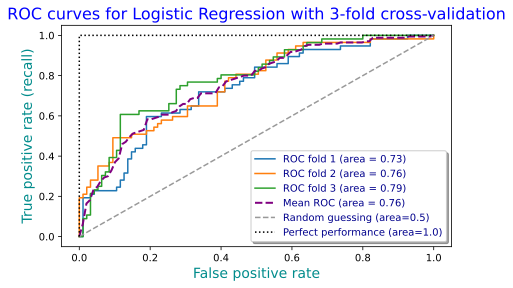

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
# the interp function is used for linear interpolation, which is helpful in smoothing curves like the
# ROC curve
from numpy import interp

# creates a pipeline 'pipe_lr' that consists of two components: StandardScaler(), which standardizes
# the features by removing the mean and scaling to unit variance; and then we can use the 
# LogisticRegression with some parameters as the classifier
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0))
# only keeps features number 4 and 14 of the initial set of features
X_train2 = X_train[:, [4, 14]]
# 'StratifiedKFold(n_splits=3)' does one single split of X_train2 into 3 disjoint subsets (folds),
# preserving the class distribution
# then 'split(X_train, y_train)' iterates over these folds, each time selecting a different fold as
# a validation set and the other two as the training set; the training set is written first
# at last, 'list(...)' just stores the results in a list for later use
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 4))
plt.title("ROC curves for Logistic Regression with 3-fold cross-validation", fontsize=16, color='blue')
# initializes the mean true positive rate to 0.0; this variable will be used to accumulate the true
# positive rates across different folds
mean_tpr = 0.0
# initializes an empty list to store the true positive rates for each fold
all_tpr = []
# creates an array of 100 evenly spaced values between 0 and 1, both included, representing the false
# positive rates. This array will be used as the x-axis values for plotting the ROC curve.
mean_fpr = np.linspace(0, 1, 100)
# loops over the three partitions (rows) of 'cv'
for i, (train, test) in enumerate(cv):
    # fits the pipeline 'pipe_lr' to the training data for the current fold (X_train2[train]) and then
    # predicts probabilities for the test data (X_train2[test]); thus each row of 'probas' is composed
    # of 2 numbers, the probability that the corresponding row of X_train2[test] belongs to class 0,
    # and the probability that it belongs to class 1
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    # scikit-learn decides based on probas[:, 1] on a list of thresholds, which are here returned in
    # the 'thresholds' variable; for each threshold it computes the corresponding false positive rate
    # and true positive rate according to the list of true classes (y_train[test]) and the list of the
    # probabilities predicted for X_train2[test] (probas[:, 1]) - if the threshold is less than
    # proba[n,1] then the n-th test instance will be predicted as positive, and a comparison with
    # y_train[test[n]] will tell if the prediction is true or false; the ratio of false positives will
    # be stored in 'fpr' and the ratio of true positives will be stored in 'tpr' -; in the end 'fpr'
    # and 'tpr' are lists of the same length than 'thresholds' and contain the ratios of false and
    # true positives for the various thresholds.
    # Note that the thresholds are arranged in decreasing order
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1])
    # in order to draw (an approximation of) the ROC curve we defined a set of 100 abscissae equally
    # distributed from 0 to 1 (via mean_fpr = np.linspace(0, 1, 100)); now for each abscissa x we want
    # to find the point of the ROC whose abscissa is x, ie the point whose ordinate y is the TPR
    # corresponding to the threshold such that the associated FPR would be x. Instead of trying to
    # find this threshold we find in the 'fpr' list the two nearest values x1 and x2 such that
    # x1 <= x <= x2; thanks to the previous line of the code we know the TPR at these abscissae : they
    # are the values in the 'tpr' list with the same index than x1 and x2 in 'fpr' respectively, and
    # we use these values to get an approximation of y using the linear interpolation
    # y = y1 + [(y2-y1)/(x2-x1)](x-x1)
    # we add the interpolated values obtained for each partition and later we will divide these sums by 
    # the number of partitions in 'cv' (ie 3 here); thus for each abscissa (FPR) the ordinate (TPR) used
    # will be the mean of these interpolated values
    # note that we ask to make an interpolation for each value of mean_fpr, including 0 and 1; but for
    # 0 and 1 we already know the exact values of the associated TPR, which are 0 and 1 respectively,
    # so below we will reset 'mean_tpr[0] = 0.0' and 'mean_tpr[-1] = 1.0'
    mean_tpr += interp(mean_fpr, fpr, tpr)
    # scikit-learn computes the ROC AUC (for the current fold) using the trapezoidal rule
    roc_auc = roc_auc_score(y_train[test], probas[:, 1])
    # plots the ROC curve for the current fold using FPR on the x-axis and TPR on the y-axis
    # f'ROC fold {i+1} (area = {roc_auc:.2f})' is using Python's f-string formatting to create a
    # string with formatted values. The curly braces {} denote a placeholder for the variable to be
    # inserted; eg {i+1} will be replaced with the value of 'i+1' where 'i' is the fold number, while
    # {roc_auc:.2f} will be replaced with the value of round(roc_auc, 2) (and is the same as
    # {round(roc_auc, 2)})
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# divides each value in the mean_tpr array by the number of partitions len(cv). This step is performed
# to calculate the mean of the approximated values of the true positive rate (TPR) obtained for each
# fold in the above loop
mean_tpr /= len(cv)
# we know that the ROC curve starts at (0,0), so we reset the first value of mean_tpr
mean_tpr[0] = 0.0
# we know that the ROC curve ends at (1,1), so we reset the last value of mean_tpr
mean_tpr[-1] = 1.0
# uses the 'roc_auc_score' function from scikit-learn to calculate the ROC AUC based on the true
# labels 'y_train' and the probabilities predicted by our pipeline 'pipe_lr'
mean_auc = roc_auc_score(y_train, pipe_lr.fit(X_train2, y_train).predict_proba(X_train2)[:, 1])
# plots the mean ROC curve using the mean false positive rates 'mean_fpr' and mean true positive rates
# 'mean_tpr'. The curve is dashed ('--'), the width of the line is 2 and its color is purple; a label
# is added, indicating "Mean ROC" and its AUC 'mean_auc' rounded to two decimal places
plt.plot(mean_fpr, mean_tpr, '--', lw=2, color='purple', label=f'Mean ROC (area = {mean_auc:.2f})')

# plots a dashed line from (0, 0) to (1, 1) with a gray color (0.6, 0.6, 0.6) representing random
# guessing; a label is added for reference
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
# plots a dotted line joining (0,0) to (0,1) and then (0,1) to (1,1) with a black color representing
# the ROC of a perfect classifier; a label is added for reference
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
# sets the limits of the x-axis for the plot, from -0.05 to 1.05
plt.xlim([-0.05, 1.05])
# sets the limits of the y-axis for the plot, from -0.05 to 1.05
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate', fontsize = 14, color='darkcyan')
plt.ylabel('True positive rate (recall)', fontsize = 14, color='darkcyan')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=10, labelcolor='darkblue')
plt.show()

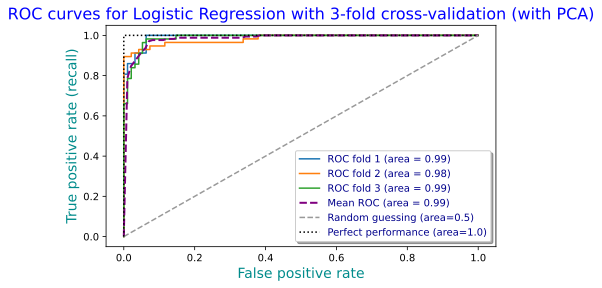

In [16]:
# This code is identical to the previous one, except that I do not reduce the set of all initial
# features to the arbitrary features number 4 and 14, but instead use a PCA(n_components=2) as the
# second step of the pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),
                        LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0))
X_train1 = X_train
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 4))
plt.title("ROC curves for Logistic Regression with 3-fold cross-validation (with PCA)", fontsize=16, color='blue')
mean_tpr = 0.0
all_tpr = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train1[train], y_train[train]).predict_proba(X_train1[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = roc_auc_score(y_train[test], probas[:, 1])
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(y_train, pipe_lr.fit(X_train1, y_train).predict_proba(X_train1)[:, 1])
plt.plot(mean_fpr, mean_tpr, '--', lw=2, color='purple', label=f'Mean ROC (area = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate', fontsize = 14, color='darkcyan')
plt.ylabel('True positive rate (recall)', fontsize = 14, color='darkcyan')
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=10, labelcolor='darkblue')
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>5d. Scoring metrics for multiclass classification</font><a id="5d"></a></p>$\quad$
        The scoring metrics that we’ve discussed so far are specific to binary classification systems. However, <font color='green'>scikit-learn</font> also implements macro and micro averaging methods to extend those scoring metrics to multiclass problems via One versus All (OvA) classification (presented in part 3, "1a. Multi-labels classification with OvA"). The micro-average is calculated from the individual TPs, FNs, TNs, and FPs of the system. For example, the micro-average of the precision score in a $k$-class system is defined by :<br><font color = darkpink>
        $$PRE_{micro} \;=\; \frac{\sum_{i=0}^{k-1}\,TP_i}{\sum_{i=0}^{k-1}\,TP_i \,+\, \sum_{i=0}^{k-1}\,FP_i} \,\qquad (8)$$</font><br>$\quad$
        The macro-average is simply defined as the average scores of the different systems :<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$PRE_{macro} \;=\; \frac{\sum_{i=0}^{k-1}\,PRE_i}{k} \,\qquad (9)$$</font>
    where $PRE_i$ is the precision for the class $i$, ie $PRE_i \;=\; \frac{TP_i}{TP_i + FP_i}$.<br><br>$\quad$
        Micro-averaging is useful if we want to weight each instance or prediction equally, whereas macro-averaging weights all classes equally.<br>$\quad$
        In <font color='green'>scikit-learn</font> the default is the weighted-macro-average :<br><font color = darkpink>
        $$PRE_{w-macro} \;=\; \frac{\sum_{i=0}^{k-1}\; m_i \, PRE_i}{m} \,\qquad (10)$$</font>
    where $m_i$ is the number of instances in class $i$, and $m$ is the total number of instances.

<a id="Appendix"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>APPENDIX - DEALING WITH CLASS IMBALANCE</font></h4>$\quad$
        We say that a dataset has a <font color='darkpink'>class imbalance</font> iff one class or multiple classes are over-represented. We can think of several domains where this may occur, such as spam filtering, fraud detection, or screening for diseases.<br>$\quad$
        If a class represents $90\%$ of a dataset then simply predicting that any instance is in this class will get a $90\%$ accuracy; so getting a $90\%$ accuracy would mean that our model hasn’t learned anything useful from the features provided in this dataset. Thus, when we fit classifiers on imbalanced datasets, it would make sense to use other metrics than accuracy when comparing different models, such as precision (see "5b. Accuracy, error, recall and precision of a classification model"), recall (idem), the ROC curve (see "5c. The receiver operating characteristic (ROC)"), whatever we
care most about in our application. For instance, our priority might be to identify the majority of patients with malignant cancer to recommend an additional screening, in which case recall should be our metric of choice; or, in spam filtering, where we don’t want to label emails as spam if the system is not very certain, precision might be a more appropriate metric.<br><p style="margin: 0 0 .5rem 0"></p>$\quad$
        Aside from metrics for evaluating machine learning models, class imbalance influences a learning algorithm during model fitting itself. Since machine learning algorithms typically optimize a reward or loss function that is computed as a sum over the training examples that it sees during fitting, the decision rule is likely going to be biased toward the majority class. So either we assign a larger penalty to wrong predictions on the minority class, or we upsample the minority class, or we downsample the majority class.<br>$\quad$
        In <font color='green'>scikit-learn</font>, adjusting penalties to alleviate biases towards the most represented classes is done by setting the <font color='green'>class_weight</font> parameter, which is implemented for most
classifiers, to <font color='green'>class_weight='balanced'</font>.<br>$\quad$
        To upsample the minority class means to add copies of instances of the minority class, typically randomly chosen with replacement, until it contains the same number of instances than the majority class. While to downsample the majority class means to randomly remove instances from the majority class until it contains the same number of instances than the minority class. In <font color='green'>scikit-learn</font> both techniques are done using the <font color='green'>resample(*arrays, replace=True, n_samples=None)</font> function from the <font color='green'>sklearn.utils</font> module of <font color='green'>scikit-learn</font> :
    <ul></font>
    <li> <font color='green'>*arrays</font> is a set of at least one array (or list) to upsample or downsample;</li>
    <li> <font color='green'>replace=True</font> means that any upsampling will be done with replacement;</li>
    <li> and <font color='green'>n_samples</font> is the desired length for all the arrays; its default value is <font color='green'>None</font>, in which case all arrays will end up with the same number of elements as the largest array provided</li></ul>$\quad$
    Let's see this on an example, in which we first remove some instances of class $1$ of our Breast Cancer Wisconsin dataset, which originally consisted of $357$ benign tumors (class $0$) and $212$ malignant tumors (class $1$), to make it more imbalanced; the new set is called 'X_imb', and the set of corresponding classes is called 'y_imb' :

In [17]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    'X_imb' contains approximately only $10\%$ of instances of class $1$ ($40$ out of $397$). And now we upsample the class $1$ : 

In [18]:
from sklearn.utils import resample
print(BB + "The initial number of instances of class 1 is :" + MB, X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0], random_state=123)

print(BB + "The final number of instances of class 1 is :" + MB, X_upsampled[y_upsampled == 1].shape[0])

The initial number of instances of class 1 is : 40
The final number of instances of class 1 is : 357


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    After resampling, we can then stack the original class $0$ samples with the upsampled class $1$ subset to obtain a balanced dataset X_bal :

In [19]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can check that our new set of instances 'X_bal' contains $357$ instances of class $0$ and $357$ instances of class $1$:

In [20]:
print(BB + "In our new set of instances X_bal, the number of instances of class 0 is :" + MB,
      X_bal[y_bal == 0].shape[0])
print(BB + "In our new set of instances X_bal, the number of instances of class 1 is :" + MB,
      X_bal[y_bal == 1].shape[0])

In our new set of instances X_bal, the number of instances of class 0 is : 357
In our new set of instances X_bal, the number of instances of class 1 is : 357
